<h1 align="center">AIND-CNC Spring Hackathon</h1>  
<h4 align="center"> May 14, 2025 </h4>   
<h4 align="center"> Credit Assignment During Learning</h4> 
    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Overview:** This notebook shows how to access and analyze data from the [Credit Assignment During Learning](https://www.allenneuraldynamics.org/projects/credit-assignment-during-learning) project established at the Allen Institute for Neural Dynamics. 

**Dataset:** Calcium activity was recorded from hundreds of cortical neurons in the mouse brain while the animal learned and performed a Brain Computer Interface (BCI) task over several days. 
    
**Goal:** This tutorial will show you how to:  
    1. load and work with neuronal calcium activity data processed via suite2p 
    2. plot event-aligned neural activity traces 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import packages and load data

In [26]:
# general imports 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
import os 
import re
import pandas as pd
from skimage import measure

# pynwb imports to open nwb files
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Metadata

In [27]:
metadata = pd.read_csv('/data/metadata.csv', index_col = False) 

metadata = metadata.sort_values(by = ['name']).reset_index()
metadata[0:10]

# to do - add FOV information 

,index,name,subject_id,session_type,genotype,virus,session_number
0,5,single-plane-ophys_731015_2025-01-10_18-06-31,731015,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,18.0
1,32,single-plane-ophys_731015_2025-01-13_20-09-20,731015,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,19.0
2,17,single-plane-ophys_731015_2025-01-24_20-00-44,731015,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,20.0
3,12,single-plane-ophys_731015_2025-01-28_17-40-57,731015,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,22.0
4,2,single-plane-ophys_731015_2025-01-28_18-56-35,731015,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,22.0
5,45,single-plane-ophys_731015_2025-01-31_20-37-19,731015,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,23.0
6,43,single-plane-ophys_740369_2025-01-09_17-18-37,740369,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,22.0
7,6,single-plane-ophys_740369_2025-01-10_20-21-40,740369,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,23.0
8,27,single-plane-ophys_740369_2025-01-13_17-31-04,740369,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,24.0
9,18,single-plane-ophys_740369_2025-01-24_21-18-11,740369,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,25.0


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Data Organization 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The metadata "name" column indicates the name of the data asset. 
    
The naming scheme for each data asset is as follows:
 > single-plane-ophys (data type) <br> 
   772414 (subject id number) <br> 
   2025-01-10_18-06-31 (experiment date (%Y-%m-%d %H:%M:%S)) <br>

In [28]:
# session_name = metadata.name[3]
# session_name

session_name = 'single-plane-ophys_731015_2025-01-24_20-00-44' 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Load Data 
    
These NWB files are stored in a Zarr format, which is optimized for large data objects stored in the cloud. To load these NWB files, we'll use the NWBZarrIO package from hdmf_zarr.
    
    
We've written a helper function that finds the nwb directory name that matches a given file_name input and loads the data. 

In [29]:
def load_nwb_by_filename(filename):
    """
    Searches the /data directory for the nwb filepath that matches the filename and loads the nwb file. 
    
    Parameters: 
    - filename (str): Data file name to match (e.g. 'single-plane-ophys_772414_2025-01-28_16-19-17') 

    Returns: 
    - nwbfile: Loaded NWBFile object if found, else None 
    """ 
    
    dir_path = [f for f in os.listdir('/data') if re.search(session_name, f)] 
    if len(dir_path) > 0: # Check if directory match successful 
        nwb_path = os.path.join('/data', dir_path[0], f'{session_name}_behavior_nwb')
        if os.path.exists(nwb_path): 
            try: 
                with NWBZarrIO(nwb_path, 'r') as io:
                    nwbfile = io.read()
                    print('Loaded NWB file from:', nwb_path)
                    return nwbfile 
            except Exception as e: 
                print(f'Error loading file from {nwb_path}: {e}')

        else: 
            print('NWB file not found at', nwb_path) 
            return None 
    else: 
        print('Directory for', session_name, 'not found') 
        return None 


In [30]:
nwbfile = load_nwb_by_filename(session_name)

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Loaded NWB file from: /data/single-plane-ophys_731015_2025-01-24_20-00-44_processed_2025-05-07_12-19-25/single-plane-ophys_731015_2025-01-24_20-00-44_behavior_nwb


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

`nwb2widget` creates an interactive widget to explore the hierarchical contents of the NWB file. The widget can also render interactive data plots (e.g. calcium activity traces, image segmentation masks). 

In [31]:
nwb2widget(nwbfile) 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### 1. Plot Calcium Activity Traces for Select ROIs 
    
The raw data was processed through Suite2p, which extracts the cell body ROIs and calculates the change in fluorescence (dff). Let's pull that data from the nwb file below. The shape of dff is (frames, roi). 
    
We'll also save the frame_rate so we can easily convert from frames to seconds. 
    

In [8]:
dff = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data

print('dff shape:',np.shape(dff))

frame_rate = nwbfile.imaging_planes["processed"].imaging_rate
print('Frame Rate:', frame_rate)

dff shape: (232140, 385)
Frame Rate: 58.2634


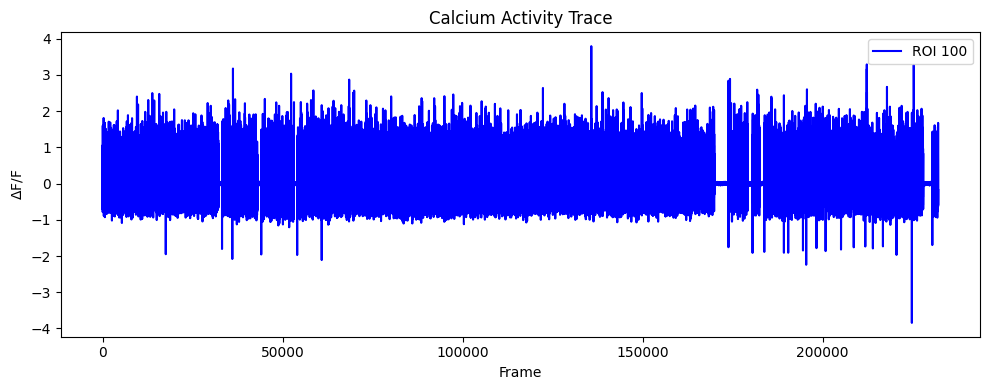

In [9]:
# Select an ROI 
ROI = 100

# Create figure with two vertically stacked plots 

# Top: Calcium trace plot
plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(dff[:, ROI], label=f'ROI {ROI}', color='blue')

plt.ylabel(r'$\Delta$F/F')
plt.xlabel('Frame')
plt.title('Calcium Activity Trace')
plt.legend(loc='upper right')


plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Experiment Structure 
    
The dff array covers the entire experimental period, which has 5 experimental epochs. 

    1. Photostimulation of single neurons * 
    2. Spontaneous activity *
    3. BCI behavior task 
    4. Spontaneous activity * 
    5. Photostimulation of single neurons * 
    

The stimulus tables in the stimulus>PhotostimTrials and the behavior table in the intervals>trials containers contains the start/stop times for each epoch. 

*In some cases, the spontaneous epoch happens before the photostimulation period. Check the stimulus tables for each data file to get the exact timing order of each epoch. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The PhotostimTrials table contains relevant information about the 2p optogenetic stimulus. 


| Column    | Description |
| -------- | ------- |
| start_time  | stimulus start (s)  |
| stop_time | stimulus end (s)   |
| start_frame | stimulus start (frame)     |
| stop_frame    | stimulus end (frame)  |
| tiff_file   | data source file name  |
| stim_name    | stimulus name   |
| laser_stim_x    | x coordinate of stimulated neuron (pixel)   |
| laser_stim_y    | y coordinate of stimulated neuron (pixel)  |
| power    | stimulus intensity (mW)  |
| duration    | stimulus time (s)  |
| stimulus_function    | stimulus type   |
| group_index    | identity of stimulated neuron(s)    |

In [10]:
photostim_table = nwbfile.stimulus["PhotostimTrials"].to_dataframe()
photostim_table


,start_time,stop_time,start_frame,stop_frame,tiff_file,stim_name,laser_stim_x,laser_stim_y,power,duration,stimulus_function,group_index
id,,,,,,,,,,,,
0,0.000000,1.132787,0,66,spont_slm_00001.tif,photostim,165.567568,196.108108,4,1.132787,scanimage.mroi.stimulusfunctions.logspiral,21
1,1.149950,2.282737,67,133,spont_slm_00002.tif,photostim,58.403226,197.983871,4,1.132787,scanimage.mroi.stimulusfunctions.logspiral,22
2,2.299900,3.415523,134,199,spont_slm_00003.tif,photostim,94.828125,75.828125,4,1.115623,scanimage.mroi.stimulusfunctions.logspiral,4
3,3.432687,4.513983,200,263,spont_slm_00004.tif,photostim,358.895833,193.479167,4,1.081296,scanimage.mroi.stimulusfunctions.logspiral,26
4,4.531146,5.629606,264,328,spont_slm_00005.tif,photostim,87.287879,189.833333,4,1.098460,scanimage.mroi.stimulusfunctions.logspiral,14
...,...,...,...,...,...,...,...,...,...,...,...,...
2336,3975.789260,3976.853393,231643,231705,spontpost_slm_01290.tif,photostim_post,340.250000,98.444444,4,1.064133,scanimage.mroi.stimulusfunctions.logspiral,35
2337,3976.870557,3977.951853,231706,231769,spontpost_slm_01291.tif,photostim_post,253.025641,218.179487,4,1.081296,scanimage.mroi.stimulusfunctions.logspiral,32
2338,3977.969017,3979.084640,231770,231835,spontpost_slm_01292.tif,photostim_post,54.409639,241.734940,4,1.115623,scanimage.mroi.stimulusfunctions.logspiral,12


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

There are two photostimulation periods - one before and one after the BCI behavior sessions. 

In [11]:
photostim_table.stim_name.unique().tolist()

['photostim', 'photostim_post']

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The behavior table contains information about the BCI epoch. 

| Column    | Description |
| -------- | ------- |
| start_time  | trial start (s)  |
| stop_time | trial end (s)   |
| BCI_go_cue |     |
| BCI_trial_hit   |     |
| BCI_lick_l  | lick times (s)   |
| BCI_reward_time   | reward delivery time (s)   |
| BCI_threshold_crossing_times    | time when reward port crossed position threshold (s)   |
| BCI_zaber_steps   | position of reward port  |
| BCI_movie_name    | data source file  |
| start_frame    | trial start (frame)  |
| stop_frame    | trial end (frame)  |
| conditioned_neuron_x    | coordinate for conditioned neuron (pixels)  |
| conditioned_neuron_y    | coordinate for conditioned neuron (pixels)  |


In [12]:
behavior_table = nwbfile.trials.to_dataframe()
behavior_table


,start_time,stop_time,BCI_go_cue,BCI_trial_hit,BCI_lick_L,BCI_reward_time,BCI_threshold_crossing_times,BCI_zaber_steps,BCI_movie_name,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y
id,,,,,,,,,,,,,
0,1393.379034,1398.699698,0.2359,True,"[1.4923000000000002, 1.6292, 1.7521, 1.8716, 1...",1.4923,1.4402,"[0.5722, 0.7792, 0.9072, 0.9882, 1.0602, 1.138...",neuron53_00001.tif,81183,81493,19.083333,22.083333
1,1398.716862,1404.260651,0.2359,True,"[2.2792, 2.4113, 2.5264, 2.6327000000000003, 2...",2.2792,2.1610,"[1.1298, 1.6857, 1.7597, 1.8227, 1.8717, 1.905...",neuron53_00002.tif,81494,81817,19.083333,22.083333
2,1404.277814,1409.546988,0.2359,True,"[1.6492, 1.7715, 1.8798, 1.9924, 2.1023, 2.216...",1.6492,1.5602,"[1.0237, 1.1028, 1.1527, 1.1997, 1.2397, 1.271...",neuron53_00003.tif,81818,82125,19.083333,22.083333
3,1409.564152,1413.923664,0.2359,True,"[0.0222, 0.9292, 1.0387, 1.1985, 1.3162, 1.437...",1.0387,1.0308,"[0.2863, 0.3373, 0.3833, 0.4243, 0.4653, 0.505...",neuron53_00004.tif,82126,82380,19.083333,22.083333
4,1413.940827,1418.471974,0.2359,True,"[1.1341, 1.2667000000000002, 1.404, 1.5119, 1....",1.2667,1.1805,"[0.3632, 0.6332, 0.7482000000000001, 0.8282, 0...",neuron53_00005.tif,82381,82645,19.083333,22.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,2255.893065,2267.976122,0.2359,True,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[0.4557, 1.8936, 2.0876, 2.1936, 2.3206, 3.146...",neuron53_00093.tif,131436,132140,19.083333,22.083333
93,2267.993286,2280.059180,0.2359,True,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[0.4833, 2.2522, 2.4282, 2.7502, 3.0952, 7.542...",neuron53_00094.tif,132141,132844,19.083333,22.083333
94,2280.076343,2287.164841,0.2359,True,"[2.0659, 2.2614, 2.3884000000000003, 2.5129, 2...",2.2614,2.1722,"[0.2863, 0.5643, 0.7813, 0.9493, 1.0412, 1.121...",neuron53_00095.tif,132845,133258,19.083333,22.083333


In [13]:
def generate_epoch_table(dff, frame_rate): 
    """
    Finds frame and time ranges for photostim, photostim_post, behavior, spontaneous, and spontaneous_post epochs from the photostim and behavior tables in the NWB files 
    
    Parameters:
    - dff (array): timeseries neural activity data 
    - frame_rate(float) 

    Returns:
    - epoch_table: pandas.DataFrame of epoch frame and time ranges 
    """

    photostim_table = nwbfile.stimulus["PhotostimTrials"].to_dataframe()
    behavior_table = nwbfile.trials.to_dataframe()
    behavior_table['stim_name'] = 'BCI'

    # Filter tables for common columns 
    shared_cols = ['start_frame', 'stop_frame', 'stim_name'] 
    filter_photostim_table = photostim_table[shared_cols]
    filter_behavior_table = behavior_table[shared_cols] 
    merged_df = pd.concat([filter_photostim_table, filter_behavior_table])

    # Sort by start_frame
    merged_df = merged_df.sort_values(by='start_frame').reset_index(drop=True)

    # Total number of frames from dff
    total_frames = len(dff)

    # Track how many spontaneous bouts have been added
    spont_count = 0
    new_rows = []

    # Check for a gap before the first event
    first_start = merged_df.iloc[0]['start_frame']
    if first_start > 0:
        spont_count += 1
        label = 'spont' if spont_count == 1 else 'spont_post' if spont_count == 2 else 'spont_uk'
        new_rows.append({
            'start_frame': 0,
            'stop_frame': first_start - 1,
            'stim_name': label
        })

    # Fill internal gaps between events
    for i in range(len(merged_df) - 1):
        current_stop = merged_df.loc[i, 'stop_frame']
        next_start = merged_df.loc[i + 1, 'start_frame']
        if next_start - current_stop > 58:
            spont_count += 1
            label = 'spont' if spont_count == 1 else 'spont_post' if spont_count == 2 else 'spont_uk'
            new_rows.append({
                'start_frame': current_stop + 1,
                'stop_frame': next_start - 1,
                'stim_name': label
            })

    # Check for a gap after the last event
    last_stop = merged_df.iloc[-1]['stop_frame']
    if total_frames - 1 - last_stop > 0:
        spont_count += 1
        label = 'spont' if spont_count == 1 else 'spont_post' if spont_count == 2 else 'spont_uk'
        new_rows.append({
            'start_frame': last_stop + 1,
            'stop_frame': total_frames - 1,
            'stim_name': label
        })

    # Add the spontaneous rows
    gap_filler_df = pd.DataFrame(new_rows)
    filled_df = pd.concat([merged_df, gap_filler_df], ignore_index=True)
    filled_df = filled_df.sort_values(by='start_frame').reset_index(drop=True)

    # Generate the epoch table
    epoch_table = (
        filled_df
        .groupby('stim_name')
        .agg(start_frame=('start_frame', 'min'),
             stop_frame=('stop_frame', 'max'))
        .reset_index()
        .sort_values(by='start_frame')
    )

    # Assume frame_rate is defined
    epoch_table['start_time'] = epoch_table['start_frame'] / frame_rate
    epoch_table['stop_time'] = epoch_table['stop_frame'] / frame_rate

    # Show result
    return epoch_table


In [14]:
epoch_table = generate_epoch_table(dff, frame_rate) 

epoch_table

,stim_name,start_frame,stop_frame,start_time,stop_time
1,photostim,0,69481,0.000000,1192.532533
3,spont,69482,81182,1192.549697,1393.361870
0,BCI,81183,134768,1393.379034,2313.081626
4,spont_post,134769,147111,2313.098789,2524.929887
2,photostim_post,147112,232139,2524.947051,3984.302324


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now, let's plot the calcium activity trace for a selected ROI, with the different stimulus epochs overlaid. We'll also show the image segmentation for the selected ROI. 

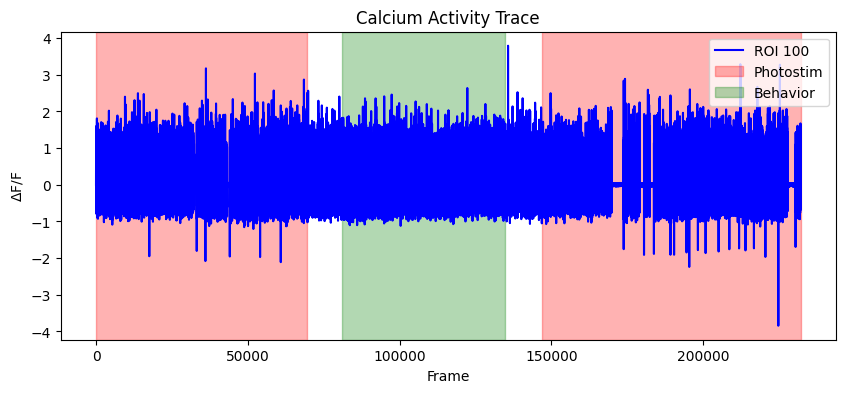

In [15]:
# Epoch parameters 
photostim_start = epoch_table[epoch_table.stim_name == "photostim"].start_frame.iloc[0]
photostim_stop = epoch_table[epoch_table.stim_name == "photostim"].stop_frame.iloc[0]

behavior_start = epoch_table[epoch_table.stim_name == "BCI"].start_frame.iloc[0]
behavior_stop = epoch_table[epoch_table.stim_name == "BCI"].stop_frame.iloc[0]

photostim_post_start = epoch_table[epoch_table.stim_name == "photostim_post"].start_frame.iloc[0]
photostim_post_stop = epoch_table[epoch_table.stim_name == "photostim_post"].stop_frame.iloc[0]

# Create figure with two vertically stacked plots 

# Top: Calcium trace plot
plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(dff[:, ROI], label=f'ROI {ROI}', color='blue')

plt.axvspan(photostim_start, photostim_stop, color='red', alpha=0.3, label='Photostim')
plt.axvspan(behavior_start, behavior_stop, color='green', alpha=0.3, label='Behavior')
plt.axvspan(photostim_post_start, photostim_post_stop, color='red', alpha=0.3)

plt.ylabel(r'$\Delta$F/F')
plt.xlabel('Frame')
plt.title('Calcium Activity Trace')
plt.legend(loc='upper right')
plt.show()

In [16]:
# Markdown content unpacking the image segmentation table 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Each row in dff represents an ROI extracted using suite2p then classified as either a soma or a dendrite. 

| Column    | Description |
| -------- | ------- |
| is_soma  | ==1 if ROI classified as soma, ==0 if not  |
| soma_probability |   |
| is_dendrite |  ==1 if ROI classified as dendrite   |
| dendrite_probability   |    |
| image_mask  | HxW sparse array defining ROI contours|

In [32]:
image_segmentation = nwbfile.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"].to_dataframe()
image_segmentation

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
0,1,0.698194,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,0.999978,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,0.998079,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,0.994995,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,1.000000,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...
380,1,1.000000,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
381,0,0.392467,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
382,1,0.999609,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


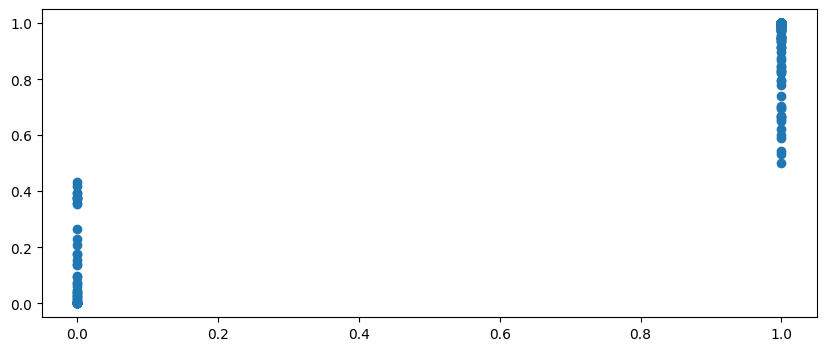

In [35]:
plt.plot(image_segmentation.is_soma[:], image_segmentation.soma_probability[:], 'o')

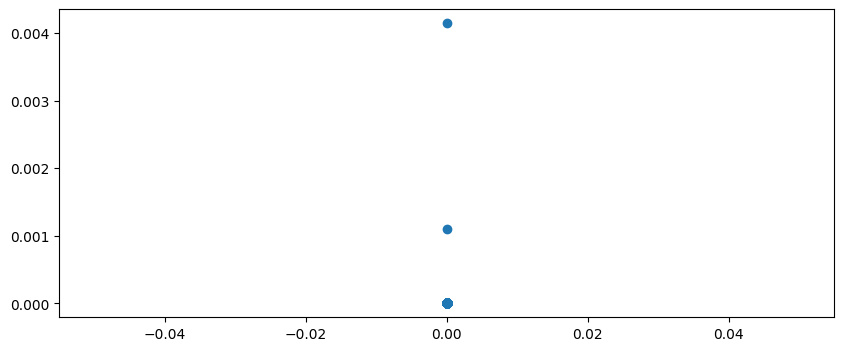

In [36]:
plt.plot(image_segmentation.is_dendrite[:], image_segmentation.dendrite_probability[:], 'o')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

After running suite2p to extract ROIs, an additional classifier is applied to the segmentations to classify somas vs dendrites. Let's filter and save both the dff array and image segmentation to contain only the ROI rows that pass soma detection (is_soma == 1) 

In [18]:
# Filter the image_segmentation table for somas 
soma_segmentation = image_segmentation[image_segmentation.is_soma == 1].reset_index() 

# Filter the dff table for rows that pass soma detection 
soma_dff = dff[:, np.where(image_segmentation.is_soma == 1)[0]]
        

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can combine information from the soma_segmentation table to identify where the ROIs are in the image. Let's add a new plot below our calcium activity trace to show the mask for our selected ROI. 
    
Another piece of data we'll load is the max projection image of the field of view. We'll overlay the ROI masks on top of this image. This is found in the processing container of the NWB. 
    
(Note that max_projection looks bad and it looks like there are many more segmentation masks thant whats in image...) 

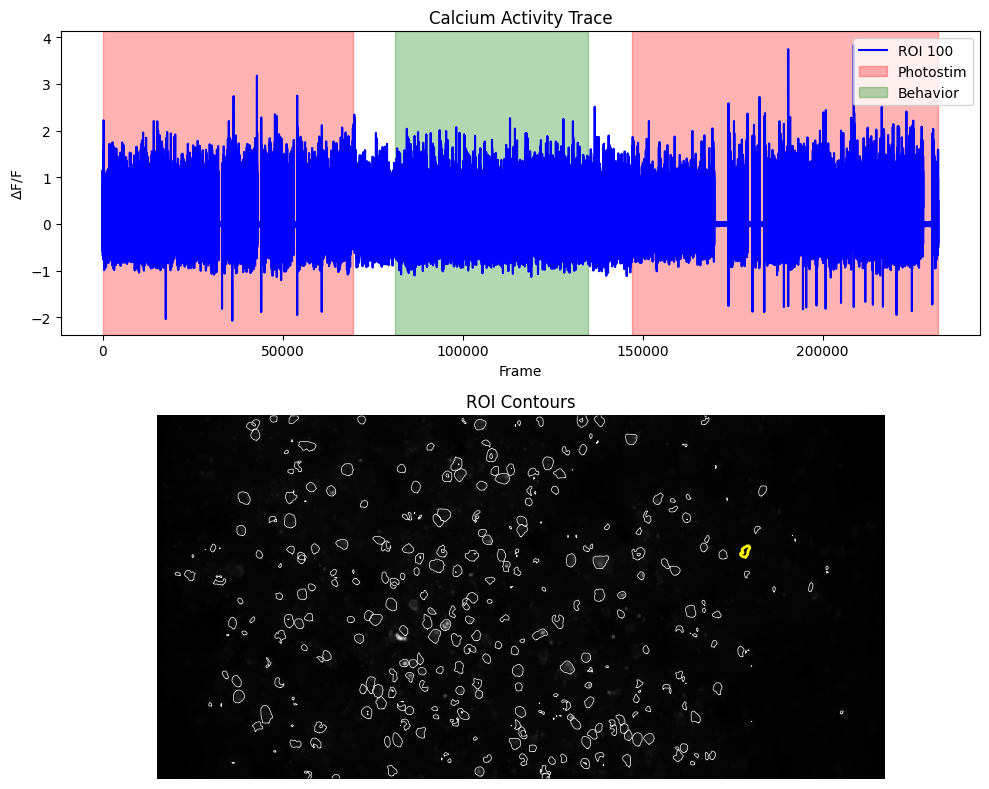

In [19]:
# Parameters 

# Select new ROI 
ROI = 100 

# Image data for FOV 
image = nwbfile.processing["processed"].data_interfaces["images"].images["average_projection"].data[:]  # shape: (H, W)

# Create figure with two vertically stacked plots 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[1, 1.2])

# Top: Calcium trace plot
ax1.plot(soma_dff[:, ROI], label=f'ROI {ROI}', color='blue')

# Add shaded regions
ax1.axvspan(photostim_start, photostim_stop, color='red', alpha=0.3, label='Photostim')
ax1.axvspan(behavior_start, behavior_stop, color='green', alpha=0.3, label='Behavior')
ax1.axvspan(photostim_post_start, photostim_post_stop, color='red', alpha=0.3)

ax1.set_ylabel(r'$\Delta$F/F')
ax1.set_xlabel('Frame')
ax1.set_title('Calcium Activity Trace')
ax1.legend(loc='upper right')

# Bottom: Grayscale image with ROI contours 
ax2.imshow(image, cmap='gray')
ax2.set_title('ROI Contours')
ax2.axis('off')

# Overlay ROI contours
for i, mask in enumerate(soma_segmentation.image_mask):
    mask_array = np.array(mask)
    contours = measure.find_contours(mask_array, level=0.5)
    for contour in contours:
        color = 'yellow' if i == ROI else 'white'
        linewidth = 2.0 if i == ROI else 0.5
        ax2.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth)

plt.tight_layout()
plt.show()

In [20]:
# stopping here for now 

In [21]:
# to do - walk through plotting change in activity with respect to distance from photostim 
# integrate over DFF curve to get strength 
# get photostim and ROI locations, calculate distance (euclidean) 
# generate plot for a single cell example (?) 

# generate plots for behavior 
# show DFF trace with behavior lick times, reward position overlaid 

In [22]:
def event_aligned_activity(dff, stimulus_frames, pre_frames, post_frames):
    """
    Extract perievent windows around stimulus frames from timeseries data

    Parameters:
    - dff: np.ndarray of shape (n_frames, n_rois)
    - stimulus_frames: list or array of stimulus frame indices
    - pre_frames: number of frames before the stimulus
    - post_frames: number of frames after the stimulus

    Returns:
    - aligned_data: np.ndarray of shape (n_events * n_rois, pre+post)
    - mean_response: np.ndarray of shape (pre+post, 1)
    """
    aligned_data = []

    for frame in stimulus_frames:
        if frame - pre_frames < 0 or frame + post_frames >= dff.shape[0]:
            continue  # Skip events too close to start or end
        for roi in range(dff.shape[1]):
            window = dff[frame - pre_frames : frame + post_frames, roi]
            aligned_data.append(window)

    aligned_data = np.stack(aligned_data, axis=0)
    mean_response = aligned_data.mean(axis=0)
    sem = stats.sem(aligned_data, axis=0) 

    return aligned_data, mean_response


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Plot mean DFF in response to photostimulation

In [23]:
# to do - instead of averaging, maybe just show a single ROI, multiple ROIs, mean, and then relative based on distance.... 
# how to calculate this? 

In [24]:
pre_frames = 30   # Number of frames before the stimulus
post_frames = 30 # Number of frames after the stimulus
stimulus_frames = photostim_table[photostim_table.stim_name == "photostim"].start_frame[0:10] # just get first 50 trials 


aligned_data, mean_response = event_aligned_activity(dff, stimulus_frames, pre_frames, post_frames)


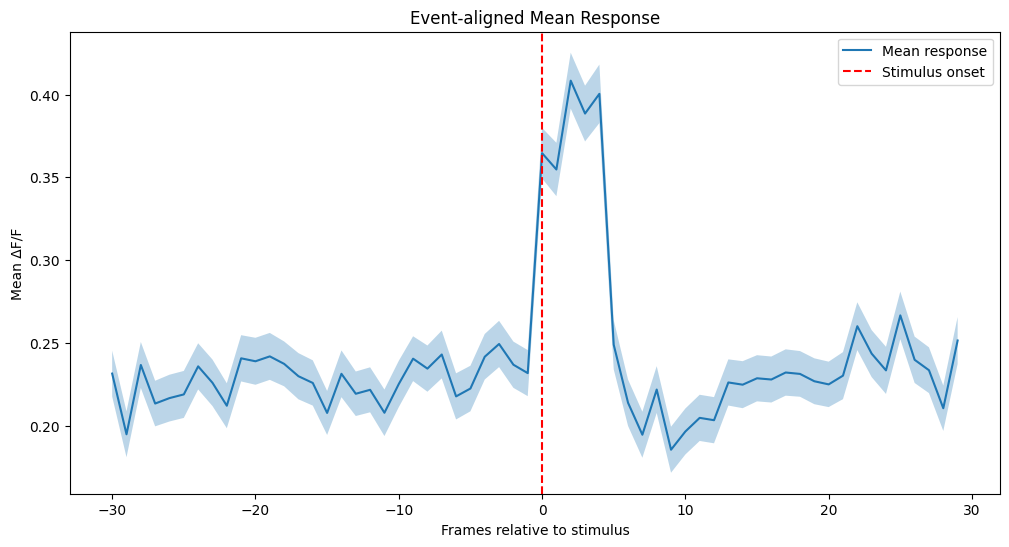

In [25]:
time = np.arange(-pre_frames, post_frames)

sem = stats.sem(aligned_data, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(time, mean_response, label='Mean response')
plt.fill_between(time, mean_response - sem, mean_response + sem, alpha=0.3)
plt.axvline(0, color='red', linestyle='--', label='Stimulus onset')
plt.xlabel('Frames relative to stimulus')
plt.ylabel('Mean ΔF/F')
plt.title('Event-aligned Mean Response')
plt.legend()
plt.show()

to do: 
    load data function x 

    metadata - identify relevant metadata to pull x 
    
    
    plot ROIs with stimulus epochs overlaid - do this programmatically pulling from tables x 
    
    PSTH/event aligned neural activity x 
    
        - opto stim x 
        
        - BCI (q: which event? motor movements?) 
        
    relate ROIs in dff to ROI masks x 
        
    neural activity of each ROI organized by distance from stim neuron, maybe plot individual ROIs in response to each photostim period? and then plot relative to how far it is from stimmulus neuron ... 
    
    nice to have: something to find connected neurons from stim periods, function to compare activity across several days 
    
    questions 